In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

rc('font', size=12)

### Global functions

In [63]:
def load_results(path, folds, f_ids, n_test, model_name): # n_test = number of test stations
    pred_y = np.zeros((len(folds), len(f_ids), n_test))#*np.nan
    test_y = np.zeros((len(folds), len(f_ids), n_test))#*np.nan
    for fold_id, fold in enumerate(folds):
        for file_id, file in enumerate(f_ids):
            try:
                pred_y[fold_id, file_id, :] = np.load(path+'results/'+model_name+'/fold_'+fold+'/'+file+'.npz')['arr_0'].ravel()
                test_y[fold_id, file_id, :] = np.load(path+'data/fold_'+fold+'/test/y/'+file+'.npz')['arr_0'].ravel()
            except:
                print(model_name,fold_id,file,'not found')
    return pred_y, test_y

def load_models(path, folds, f_ids, n_test, model_name): # n_test = number of test stations
    models = np.zeros((len(folds), len(f_ids), n_test), dtype='object')
    for fold_id, fold in enumerate(folds):
        for file_id, file in enumerate(f_ids):
            models[fold_id, file_id, :] = pd.read_pickle(path+'results/'+model_name+'/fold_'+fold+'/'+file+'.model')
    return models

def fold_wise_rmse(pred_y, test_y, n_folds): # 2D RMSE per fold
    rmse = []
    for i in range(n_folds):
        tmp = mean_squared_error(test_y[i,:,:].ravel(), pred_y[i,:,:].ravel(), squared=False)
#         print('Fold',i,'RMSE:',round(tmp, 3))
        rmse.append(tmp)
    return rmse

def fold_wise_r2(pred_y, test_y, n_folds): # 2D RMSE per fold
    r2 = []
    for i in range(n_folds):
        tmp = r2_score(test_y[i,:,:].ravel(), pred_y[i,:,:].ravel())
#         print('Fold',i,'RMSE:',round(tmp, 3))
        r2.append(tmp)
    return r2
        
def plot_pred_vs_test(pred_y, test_y, n_folds):
    fig, ax = plt.subplots(1, n_folds, sharex=True, sharey=True, figsize=(15,3))
    for i in range(n_folds):
        ax[i].plot(test_y[i,:,:].ravel(), test_y[i,:,:].ravel())
        ax[i].scatter(test_y[i,:,:].ravel(), pred_y[i,:,:].ravel())
    ax[0].set_xlabel('Ground truth');
    ax[0].set_ylabel('Predicted values');

# Global config

In [64]:
f_ids = [str(i).zfill(5) for i in range(277)]
folds = [str(i) for i in range(6)]
n_test = 6

## beijing-pm2.5 interpolated met data

In [65]:
path = '../production/pm25_beijing_best36/linear/'

### All models

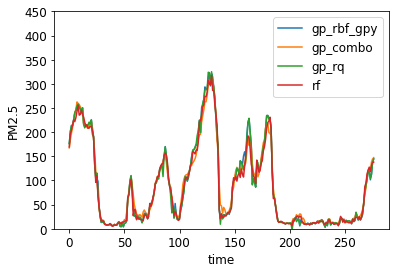

In [66]:
# models = ['rf','svr', 'gp_m32', 'gp_m12', 'gp_linear','elst','dt','dkl', 
#           'gp_rbf_gpytorch', 'gp_sm_gpytorch', 'gp_rbf_gpy', 
#           'gp_rbf_torch', 'gp_rbf', 'nsgp_rbf', 'mlp', 'gp_fi', 'gp_combo']#,'gp_rbf_gpflow']]
models = ['gp_rbf_gpy', 'gp_combo', 'gp_rq', 'rf']
res = pd.DataFrame(index=models, columns=['fold_'+str(i) for i in range(len(folds))]+['average'])
r2res = pd.DataFrame(index=models, columns=['fold_'+str(i) for i in range(len(folds))]+['average'])
for model in models:
    pred_y, test_y = load_results(path, folds, f_ids, n_test, model)
    plt.plot(pred_y[0,:,0], label=model)
#     plt.plot(test_y[0,:,0])
#     plot_pred_vs_test(pred_y, test_y, len(folds))
#     plt.figure()
#     plt.plot(test_y[0,:,0])
#     plt.plot(pred_y[0,:,0])
    fold_rmse = fold_wise_rmse(pred_y, test_y, len(folds))
    fold_rmse.append(np.mean(fold_rmse))
    res.loc[model, :] = fold_rmse
    
    fold_r2 = fold_wise_r2(pred_y, test_y, len(folds))
    fold_r2.append(np.mean(fold_r2))
    r2res.loc[model, :] = fold_r2
plt.ylim(0,450);
plt.xlabel('time')
plt.ylabel('PM2.5')
plt.legend(bbox_to_anchor=[1,1]);

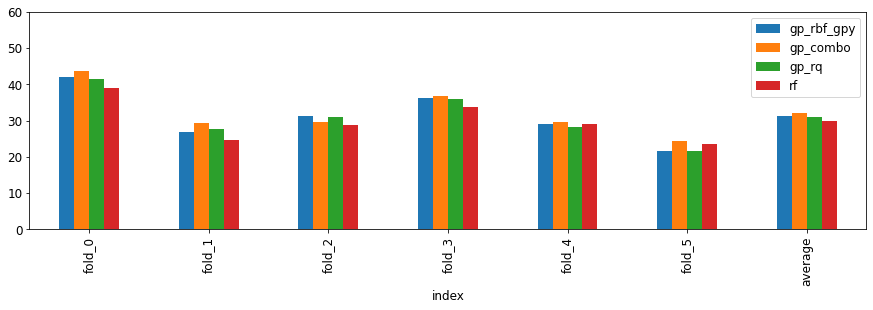

In [67]:
fig,ax = plt.subplots(figsize=(15,4))
res.T.reset_index().plot(x='index',y=res.T.columns,kind='bar',ax=ax)
plt.ylim(0,60);
plt.legend(bbox_to_anchor=[1,1]);

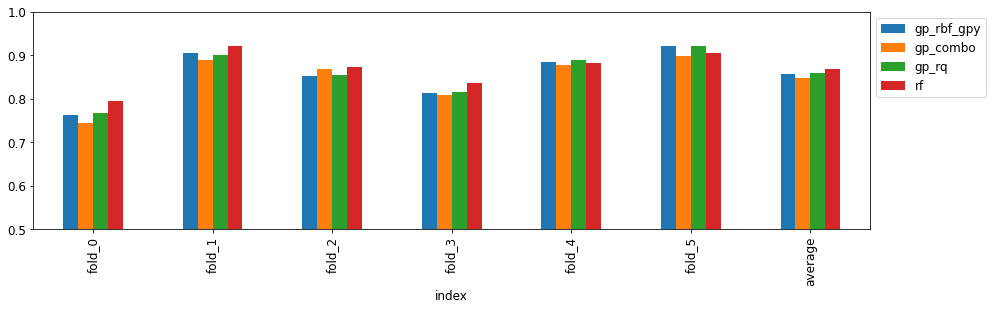

In [68]:
fig,ax = plt.subplots(figsize=(15,4))
r2res.T.reset_index().plot(x='index',y=r2res.T.columns,kind='bar',ax=ax)
plt.ylim(0.5,1);
plt.legend(bbox_to_anchor=[1,1]);

In [69]:
resf = res.copy()
for col in res.columns:
    for i in res.index:
        resf.loc[i, col] = "{:.2f} rmse".format(float(res.loc[i, col]))
print(resf.to_markdown().replace('rmse',''))

|            | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     | average    |
|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
| gp_rbf_gpy | 42.09  | 26.98  | 31.30  | 36.12  | 28.97  | 21.52  | 31.16  |
| gp_combo   | 43.56  | 29.39  | 29.55  | 36.74  | 29.70  | 24.37  | 32.22  |
| gp_rq      | 41.54  | 27.70  | 31.10  | 35.91  | 28.28  | 21.55  | 31.01  |
| rf         | 39.11  | 24.69  | 28.87  | 33.87  | 29.10  | 23.60  | 29.87  |


In [38]:
resf = r2res.copy()
for col in r2res.columns:
    for i in r2res.index:
        resf.loc[i, col] = "{:.2f} rmse".format(float(r2res.loc[i, col]))
print(resf.to_markdown().replace('rmse',''))

|            | fold_0    | fold_1    | fold_2    | fold_3    | fold_4    | fold_5    | average   |
|:-----------|:----------|:----------|:----------|:----------|:----------|:----------|:----------|
| gp_rbf_gpy | 0.76  | 0.91  | 0.85  | 0.81  | 0.88  | 0.92  | 0.86  |
| gp_combo   | 0.74  | 0.89  | 0.87  | 0.81  | 0.88  | 0.90  | 0.85  |
| gp_rq      | 0.77  | 0.90  | 0.85  | 0.82  | 0.89  | 0.92  | 0.86  |
| rf         | 0.79  | 0.92  | 0.87  | 0.84  | 0.88  | 0.91  | 0.87  |


|        |   fold_0 |   fold_1 |   fold_2 |   fold_3 |   fold_4 |   fold_5 |   average |
|:-------|---------:|---------:|---------:|---------:|---------:|---------:|----------:|
| gp_rbf |  43.1771 |    23.67 |  27.9796 |  33.4051 |  26.8317 |  21.6923 |   29.4593 |

## Checking Win:Loss ratio between GP-RBF and DKL

In [103]:
pred_lin, test_lin = load_results(path, folds, f_ids, n_test, 'mlp')
pred_rbf, test_rbf = load_results(path, folds, f_ids, n_test, 'gp_rbf_gpytorch')
pred_rf, test_rf = load_results(path, folds, f_ids, n_test, 'rf')
pred_dkl, test_dkl = load_results(path, folds, f_ids, n_test, 'dkl')
print('|        |   fold_0 |   fold_1 |   fold_2 |   fold_3 |   fold_4 |   fold_5 |   total |')
print('|:-------|---------:|---------:|---------:|---------:|---------:|---------:|----------:|')
print('|DKL:RBF|',end='')
rbf_c = 0
dkl_c = 0
for i in range(pred_rbf.shape[0]):
    diff_rbf = np.abs(pred_rbf[i].ravel() - test_rbf[i].ravel())
    diff_dkl = np.abs(pred_dkl[i].ravel() - test_dkl[i].ravel())
    rbf_c += np.sum(diff_dkl>diff_rbf)
    dkl_c += np.sum(diff_dkl<diff_rbf)
    print(np.sum(diff_dkl<diff_rbf),':', np.sum(diff_dkl>diff_rbf),sep='',end='|')
print(dkl_c,':',rbf_c,end='|')

|        |   fold_0 |   fold_1 |   fold_2 |   fold_3 |   fold_4 |   fold_5 |   total |
|:-------|---------:|---------:|---------:|---------:|---------:|---------:|----------:|
|DKL:RBF|786:876|799:863|765:897|873:789|803:859|734:928|4760 : 5212|

1035


44.41907280028349

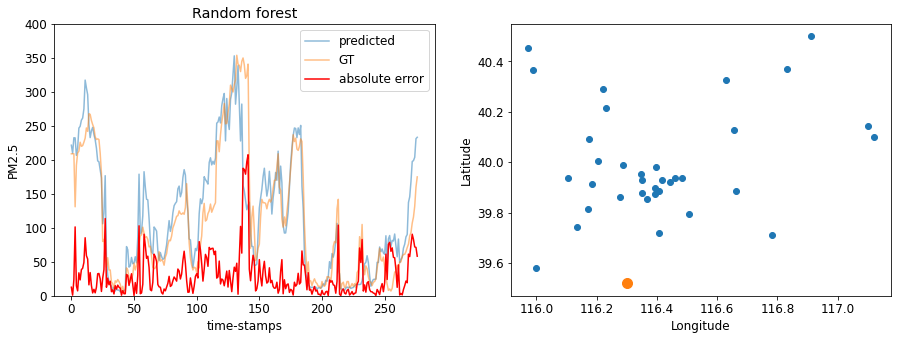

In [121]:
f = 1
i = 5
pred = pred_rbf
test = test_rbf
name = 'Random forest'
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(pred[f,:,i], label='predicted', alpha=0.5);
ax[0].plot(test[f,:,i], label='GT', alpha=0.5);
# plt.figure()
ax[0].plot(np.abs(pred[f,:,i] - test[f,:,i]), c='r', label='absolute error');
ax[0].legend();
ax[0].set_ylim(0,400);
ax[0].set_xlabel('time-stamps')
ax[0].set_ylabel('PM2.5')
all_locs = station_df[['longtitude', 'latitude']]
stn = int(df_shw.iloc[i, f].split()[-1])
print(stn)
ax[1].scatter(all_locs.values[:,0], all_locs.values[:,1])
ax[1].scatter(all_locs.loc[stn][0], all_locs.loc[stn][1], s=100);
ax[1].set_xlabel('Longitude');
ax[1].set_ylabel('Latitude');
ax[0].set_title(name);
mean_squared_error(test[f,:,i], pred[f,:,i], squared=False)

In [120]:
tt = 0
mm = pd.read_pickle(path+'results/'+'gp_rbf_gpy'+'/fold_'+str(f)+'/'+str(tt).zfill(5)+'.model')

mm.predict(np.array([]))

(array([[0.]]), array([[0.47702266]]))

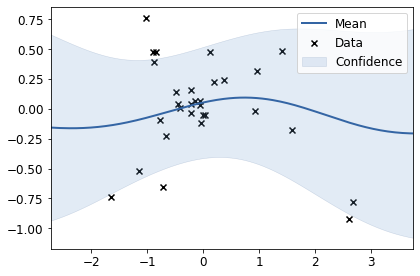

In [119]:
mm.plot(visible_dims=[0]);

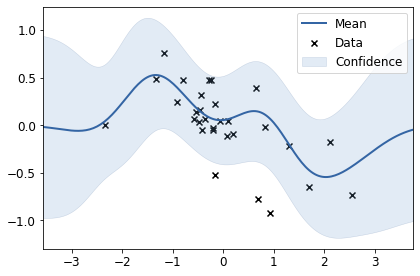

In [115]:
mm.plot(visible_dims=[1]);

## Checking Win:Loss ratio station wise

In [91]:
df_shw = pd.DataFrame(np.zeros((6,6)), index=range(1,7), columns=['fold_'+str(i) for i in range(6)])
df_shw.index.name = 'Test Station'
for fold_i in range(6):
    diff_lin = np.abs(pred_lin[fold_i] - test_lin[fold_i])
    diff_dkl = np.abs(pred_dkl[fold_i] - test_dkl[fold_i])
    for s_i in range(6):
        rbf_c = np.sum(diff_lin[:,s_i]<diff_dkl[:,s_i])
        dkl_c = np.sum(diff_dkl[:,s_i]<diff_lin[:,s_i])
        df_shw.iloc[s_i, fold_i] = str(dkl_c)+':'+str(rbf_c)
print(df_shw.to_markdown())

|   Test Station | fold_0   | fold_1   | fold_2   | fold_3   | fold_4   | fold_5   |
|---------------:|:---------|:---------|:---------|:---------|:---------|:---------|
|              1 | 116:161  | 135:142  | 152:125  | 159:118  | 122:155  | 130:147  |
|              2 | 151:126  | 135:142  | 129:148  | 141:136  | 139:138  | 116:161  |
|              3 | 136:141  | 139:138  | 129:148  | 160:117  | 165:112  | 136:141  |
|              4 | 122:155  | 107:170  | 125:152  | 124:153  | 133:144  | 133:144  |
|              5 | 109:168  | 127:150  | 126:151  | 163:114  | 171:106  | 116:161  |
|              6 | 127:150  | 213:64   | 135:142  | 142:135  | 157:120  | 162:115  |


### Stationwise RMSE

0 5 73.56364036240214
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 19.48 1014 | 15.29 1009 | 31.04 1001 | 38.77 1002 | 16.76 1011 | 16.24 1007 |
|              2 | 30.24 1017 | 15.44 1010 | 41.37 1005 | 28.56 1003 | 39.05 1019 | 14.99 1008 |
|              3 | 26.31 1027 | 13.78 1013 | 31.17 1006 | 41.17 1004 | 35.30 1023 | 16.72 1015 |
|              4 | 36.83 1031 | 23.39 1018 | 29.25 1016 | 16.35 1012 | 24.19 1024 | 25.64 1021 |
|              5 | 45.85 1032 | 22.22 1022 | 20.18 1020 | 42.01 1025 | 36.00 1028 | 31.39 1026 |
|              6 | 73.56 1036 | 61.50 1035 | 25.40 1030 | 44.69 1034 | 30.09 1033 | 45.79 1029 |


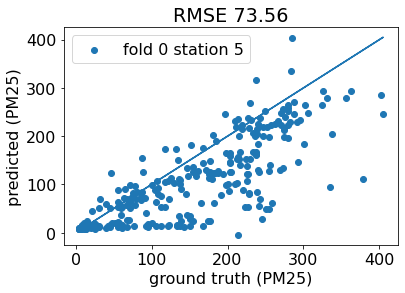

In [92]:
df_shw = pd.DataFrame(np.zeros((6,6)), index=range(1,7), columns=['fold_'+str(i) for i in range(6)])
df_shw.index.name = 'Test Station'
for fold_i in range(6):
    stn = pd.read_pickle(path+'data/fold_'+str(fold_i)+'/test_stations.pickle')
#     print(stn)
    diff_lin = np.abs(pred_lin[fold_i] - test_lin[fold_i])
#     diff_dkl = np.abs(pred_dkl[fold_i] - test_dkl[fold_i])
    for s_i in range(6):
        df_shw.iloc[s_i, fold_i] = '{:.2f}'.format(mean_squared_error(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], 
                                                                squared=False))+' '+str(stn[s_i])
        if (fold_i, s_i) in [(0,5)]:
            z_tst, z_prd = test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i]
            plt.plot(test_lin[fold_i,:,s_i], test_lin[fold_i,:,s_i])
            plt.scatter(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], label='fold '+str(fold_i)+' station '+str(s_i))
            plt.xlabel('ground truth (PM25)')
            plt.ylabel('predicted (PM25)')
            plt.title('RMSE {:.2f}'.format(mean_squared_error(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], 
                                                                squared=False)))
            print(fold_i, s_i, mean_squared_error(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], squared=False))
print(df_shw.to_markdown())
plt.legend();

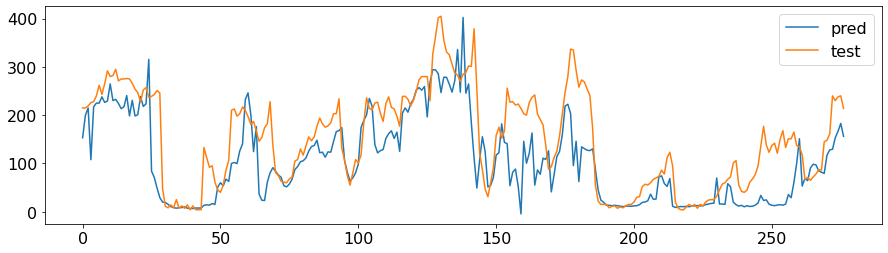

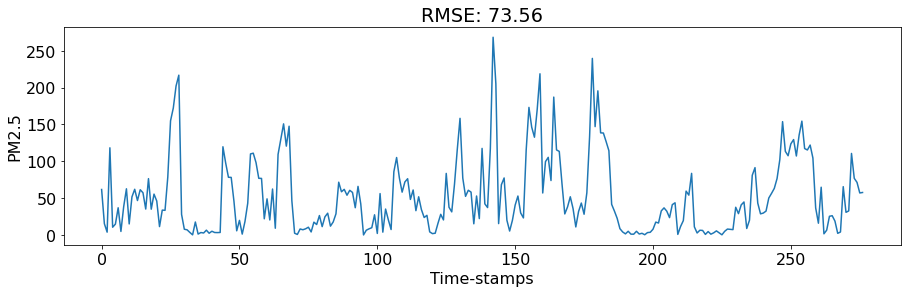

In [95]:
plt.figure(figsize=(15, 4))
plt.plot(z_prd, label='pred');
plt.plot(z_tst, label='test');
plt.legend();
plt.figure(figsize=(15, 4));
plt.plot(np.abs(z_prd-z_tst))
a = mean_squared_error(z_prd, z_tst, squared=False).round(2)
# b = mean_squared_error(np.hstack([z_tst[:142], z_tst[143:]]), np.hstack([z_prd[:142], z_prd[143:]]), squared=False).round(2)
plt.title('RMSE: '+str(a));#'before '+str(a)+' after '+str(b));
plt.xlabel('Time-stamps');
plt.ylabel('PM2.5');

### Station-wise R^2

In [14]:
df_shw = pd.DataFrame(np.zeros((6,6)), index=range(1,7), columns=['fold_'+str(i) for i in range(6)])
df_shw.index.name = 'Test Station'
for fold_i in range(6):
    stn = pd.read_pickle(path+'data/fold_'+str(fold_i)+'/test_stations.pickle')
#     print(stn)
    diff_lin = np.abs(pred_lin[fold_i] - test_lin[fold_i])
#     diff_dkl = np.abs(pred_dkl[fold_i] - test_dkl[fold_i])
    for s_i in range(6):
        df_shw.iloc[s_i, fold_i] = '{:.2f}'.format(r2_score(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], 
                                                                    ))+' '+str(stn[s_i])
print(df_shw.to_markdown())

|   Test Station | fold_0    | fold_1    | fold_2    | fold_3    | fold_4    | fold_5    |
|---------------:|:----------|:----------|:----------|:----------|:----------|:----------|
|              1 | 0.95 1014 | 0.97 1009 | 0.83 1001 | 0.63 1002 | 0.96 1011 | 0.96 1007 |
|              2 | 0.89 1017 | 0.97 1010 | 0.77 1005 | 0.85 1003 | 0.87 1019 | 0.96 1008 |
|              3 | 0.86 1027 | 0.97 1013 | 0.85 1006 | 0.71 1004 | 0.83 1023 | 0.95 1015 |
|              4 | 0.48 1031 | 0.94 1018 | 0.89 1016 | 0.96 1012 | 0.87 1024 | 0.92 1021 |
|              5 | 0.57 1032 | 0.94 1022 | 0.93 1020 | 0.59 1025 | 0.81 1028 | 0.80 1026 |
|              6 | 0.44 1036 | 0.54 1035 | 0.82 1030 | 0.85 1034 | 0.81 1033 | 0.46 1029 |


## Time wise R^2

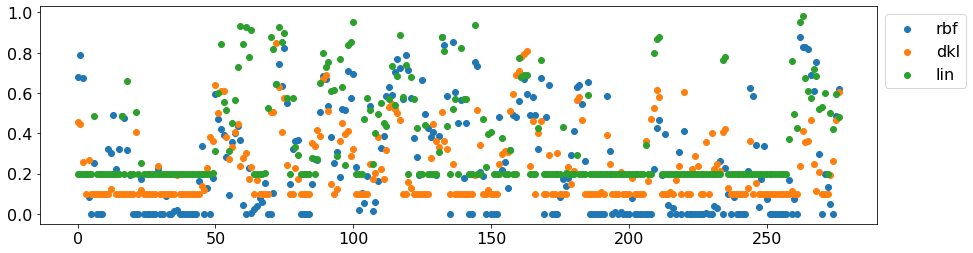

In [16]:
fold = 0
r2rbf = []
r2dkl = []
r2lin = []

plt.figure(figsize=(15,4))
for t in range(277):
    r2rbf.append(max(0,r2_score(test_rbf[fold, t, :], pred_rbf[fold, t, :])))
    r2dkl.append(max(0.1,r2_score(test_dkl[fold, t, :], pred_dkl[fold, t, :])))
    r2lin.append(max(0.2,r2_score(test_lin[fold, t, :], pred_lin[fold, t, :])))
plt.scatter(range(len(r2rbf)), r2rbf, label='rbf');
plt.scatter(range(len(r2rbf)), r2dkl, label='dkl');
plt.scatter(range(len(r2rbf)), r2lin, label='lin');
plt.legend(bbox_to_anchor=(1,1));

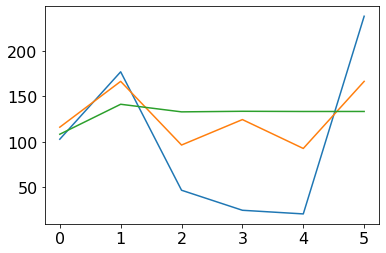

In [17]:
plt.plot(test_lin[0,-3,:]);
plt.plot(pred_lin[0,-3,:]);
plt.plot(pred_rbf[0,-3,:]);

### Feature importance in RF

In [81]:
models = load_models(path, folds, f_ids, n_test, 'rf')

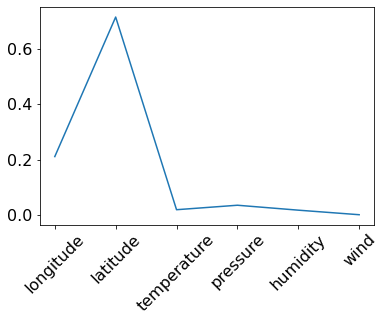

In [97]:
fold = 0
for t in []:
    plt.plot(range(6), models[fold,t,0].best_estimator_.feature_importances_)

Xcols = ['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind']
plt.xticks(ticks=range(6), labels=Xcols, rotation = 45);

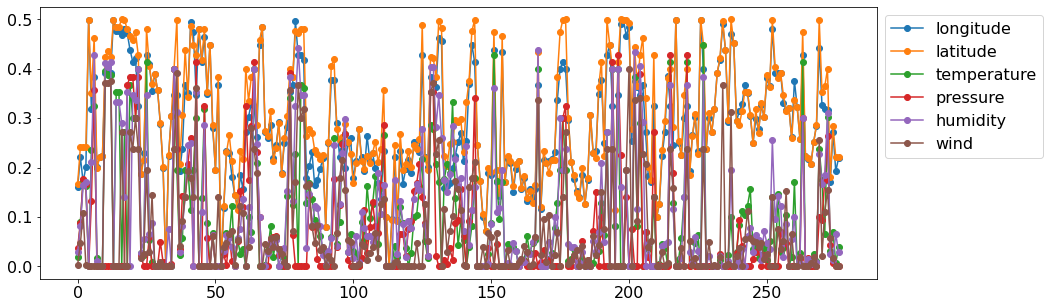

In [99]:
fold = 5
all_f = np.zeros((277,6))
for t in range(277):
    all_f[t,:] = np.std([tree.feature_importances_ for tree in models[fold,t,0].best_estimator_.estimators_], axis=0)

Xcols = ['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind']
plt.figure(figsize=(15,5))
for f in range(6):
    plt.plot(range(277), all_f[:,f], 'o-',label=Xcols[f])
plt.legend(bbox_to_anchor=(1,1));

### Feature importance in ElasticNet

In [43]:
models = load_models(path, folds, f_ids, n_test, 'elst')

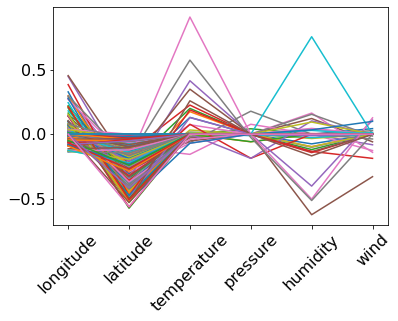

In [45]:
fold = 5
for t in range(277):
    plt.plot(range(6), models[fold,t,0].best_estimator_.coef_)

Xcols = ['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind']
plt.xticks(ticks=range(6), labels=Xcols, rotation = 45);

## Most frequant hyperparameters

### SVR

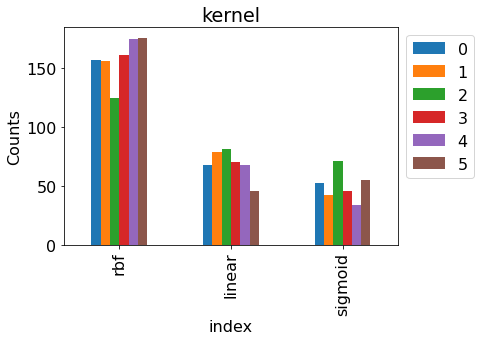

In [46]:
c = ['g','k','b','y','r','c']
hyp = 'kernel'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/svr/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

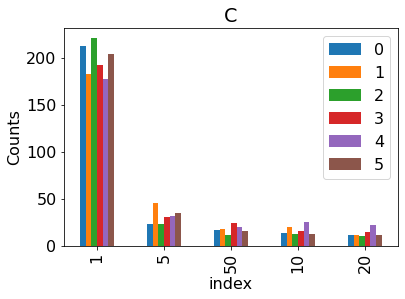

In [47]:
c = ['g','k','b','y','r','c']
hyp = 'C'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/svr/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

### Random forest

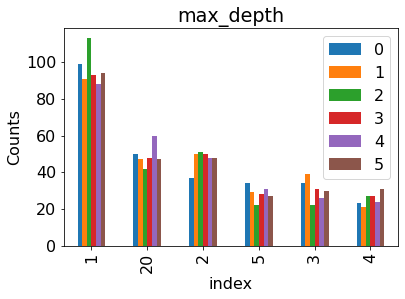

In [48]:
c = ['g','k','b','y','r','c']
hyp = 'max_depth'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/rf/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

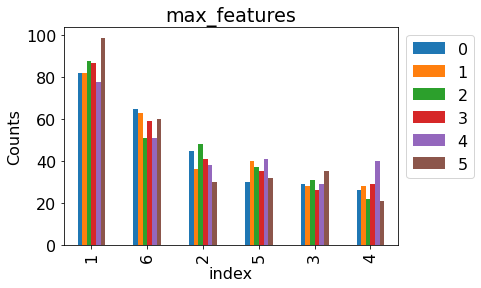

In [49]:
c = ['g','k','b','y','r','c']
hyp = 'max_features'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/rf/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

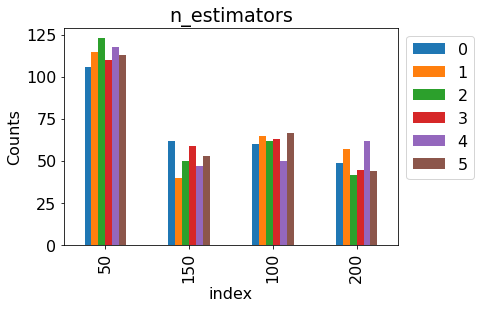

In [50]:
c = ['g','k','b','y','r','c']
hyp = 'n_estimators'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/rf/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

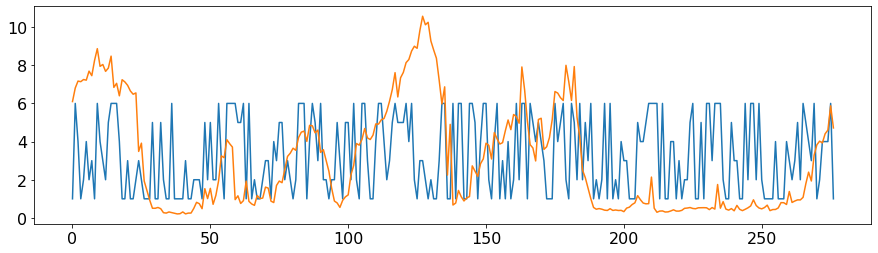

In [83]:
c = ['g','k','b','y','r','c']
hyp = 'max_features'
res_df = pd.DataFrame(columns=range(len(folds)))
plt.figure(figsize=(15,4))
for fold in range(len(folds)):
    fwise = []
    preds = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/rf/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        pred_y = np.load(path+'results/rf/fold_'+str(fold)+'/'+file+'.npy')[0]
        fwise.append(val)
        preds.append(pred_y/30)
    plt.plot(fwise)
    plt.plot(preds)
    break

### Decision tree

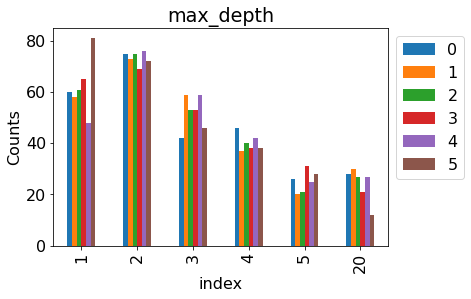

In [91]:
c = ['g','k','b','y','r','c']
hyp = 'max_depth'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        val = pd.read_pickle(path+'results/dt/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        fwise.append(val)
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.sort_index().reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

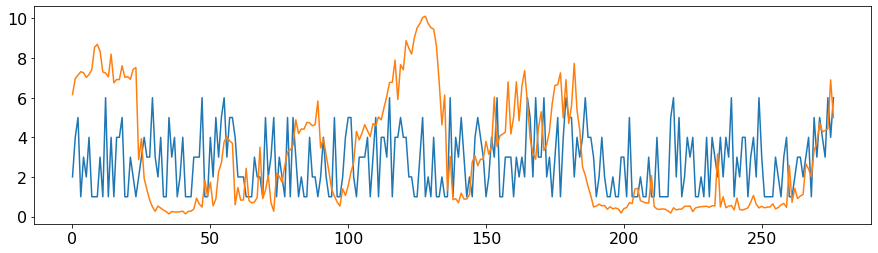

In [118]:
c = ['g','k','b','y','r','c']
hyp = 'max_features'
res_df = pd.DataFrame(columns=range(len(folds)))
plt.figure(figsize=(15,4))
for fold in range(len(folds)):
    fwise = []
    preds = []
    for file in f_ids:
        if file=='00175':
            m_test = pd.read_pickle(path+'results/dt/fold_'+str(fold)+'/'+file+'.model')
        val = pd.read_pickle(path+'results/dt/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
        pred_y = np.load(path+'results/dt/fold_'+str(fold)+'/'+file+'.npy')[0]
#         print(file,pred_y)
        fwise.append(val)
        preds.append(pred_y/30)
    plt.plot(fwise)
    plt.plot(preds)
    break

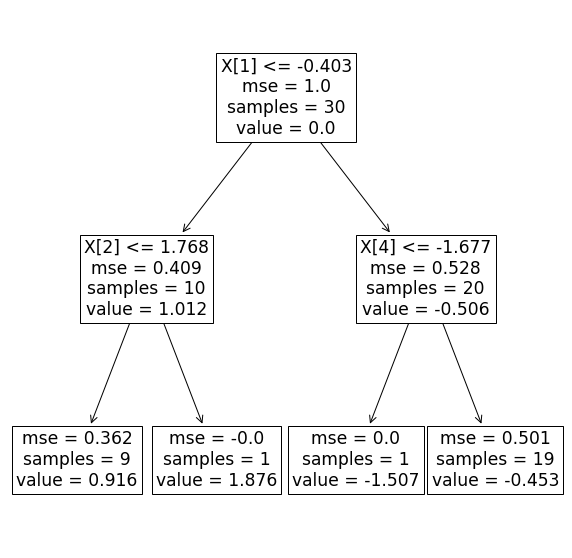

In [119]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(figsize=(10,10))
plot_tree(m_test.best_estimator_, ax=ax);

### Elastic net

1 00061 not found
1 00126 not found


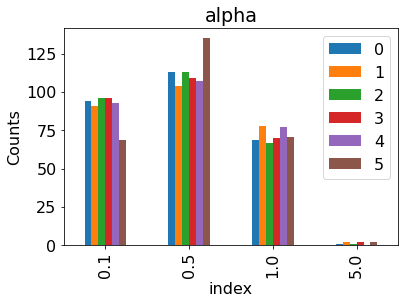

In [66]:
c = ['g','k','b','y','r','c']
hyp = 'alpha'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        try:
            val = pd.read_pickle(path+'results/elst/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
            fwise.append(val)
        except:
            print(fold,file,'not found')
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.sort_index().reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

1 00061 not found
1 00126 not found


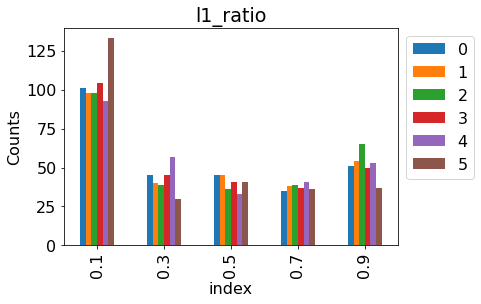

In [67]:
c = ['g','k','b','y','r','c']
hyp = 'l1_ratio'
res_df = pd.DataFrame(columns=range(len(folds)))
for fold in range(len(folds)):
    fwise = []
    for file in f_ids:
        try:
            val = pd.read_pickle(path+'results/elst/fold_'+str(fold)+'/'+file+'.model').best_params_[hyp]
            fwise.append(val)
        except:
            print(fold,file,'not found')
    res_df[fold] = pd.Series(fwise).value_counts()#.plot(kind='bar', alpha=0.2, color=c[fold])
res_df = res_df.sort_index().reset_index()
res_df.plot(x='index', y=res_df.columns[1:], kind='bar')
plt.ylabel('Counts');
plt.title(hyp)
plt.legend(bbox_to_anchor=[1,1]);

# Plot stations with RMSE weights

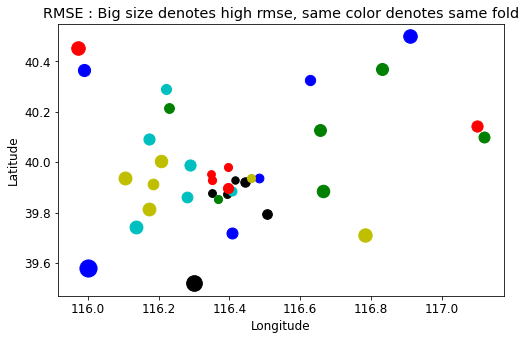

In [41]:
station_df = pd.read_csv('../raw_data/Air20Quality20Data/Beijing/Station.txt').set_index('station_id')
df_shw = pd.DataFrame(np.zeros((6,6)), index=range(1,7), columns=['fold_'+str(i) for i in range(6)])
df_shw.index.name = 'Test Station'
stn_rmse = []
for fold_i in range(6):
    stn = pd.read_pickle(path+'data/fold_'+str(fold_i)+'/test_stations.pickle')
#     print(stn)
    diff_lin = np.abs(pred_lin[fold_i] - test_lin[fold_i])
#     diff_dkl = np.abs(pred_dkl[fold_i] - test_dkl[fold_i])
    for s_i in range(6):
        df_shw.iloc[s_i, fold_i] = '{:.2f}'.format(mean_squared_error(test_lin[fold_i,:,s_i], pred_lin[fold_i,:,s_i], 
                                                                squared=False))+' '+str(stn[s_i])
        stn_rmse.append(df_shw.iloc[s_i, fold_i])
c = ['b','k','c','y','g','r']
plt.figure(figsize=(8,5))
for it, item in enumerate(stn_rmse):
    rmse, stn = map(float, item.split(' '))
    plt.scatter(station_df.loc[int(stn)]['longtitude'], station_df.loc[stn]['latitude'], s=rmse*4, c=c[it//6])
plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.title('RMSE : Big size denotes high rmse, same color denotes same fold');

In [42]:
df_shw

,fold_0,fold_1,fold_2,fold_3,fold_4,fold_5
Test Station,,,,,,
1,19.48 1014,15.29 1009,31.04 1001,38.77 1002,16.76 1011,16.24 1007
2,30.24 1017,15.44 1010,41.37 1005,28.56 1003,39.05 1019,14.99 1008
3,26.31 1027,13.78 1013,31.17 1006,41.17 1004,35.30 1023,16.72 1015
4,36.83 1031,23.39 1018,29.25 1016,16.35 1012,24.19 1024,25.64 1021
5,45.85 1032,22.22 1022,20.18 1020,42.01 1025,36.00 1028,31.39 1026
6,73.56 1036,61.50 1035,25.40 1030,44.69 1034,30.09 1033,45.79 1029


### Checking model parameters

In [329]:
fold = str(0)
res5 = pd.DataFrame(np.zeros((len(f_ids), 6)), index=range(len(f_ids)), columns=['longitude', 'latitude', 'temperature', 'pressure', 'humidity', 'wind'])
for f_i, file_id in enumerate(f_ids):
    m = pd.read_pickle('../production/pm25_beijing_best36/linear/results/gp_rbf_gpy/fold_'+fold+'/'+file_id+'.model')
    res5.loc[f_i] = m.kern.lengthscale

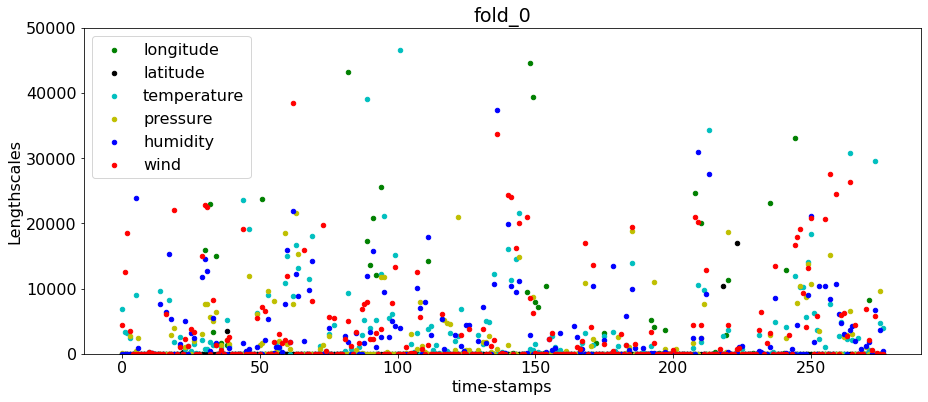

In [330]:
fig,ax = plt.subplots(figsize=(15,6))
c = ['g', 'k', 'c','y','b','r']
for c_i in range(6):
    res5[res5.columns[c_i]].reset_index().plot(x='index', y=res5.columns[c_i], ax=ax, kind='scatter', color=c[c_i], label=res5.columns[c_i]);
plt.xlabel('time-stamps');
plt.ylabel('Lengthscales');
plt.title('fold_'+fold)
plt.ylim(0,50000);

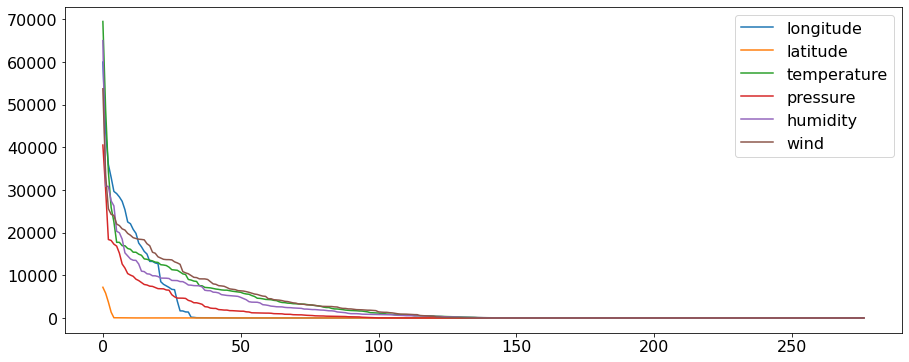

In [184]:
fig,ax = plt.subplots(figsize=(15,6))
for c_i in range(6):
    res0.sort_values(res0.columns[c_i], ascending=False)[res0.columns[c_i]].reset_index().plot(y=res0.columns[c_i], ax=ax);

### Scaled for train - all time-stamps

* Random seed 0
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 38.77 1003 | 28.21 1014 | 42.52 1007 | 34.86 1023 | 31.70 1033 | 28.74 1004 |
|              2 | 36.16 1020 | 24.46 1029 | 36.76 1025 | 38.55 1008 | 30.62 1015 | 28.41 1022 |
|              3 | 41.95 1026 | 32.68 1009 | 40.02 1018 | 34.81 1013 | 34.86 1001 | 28.37 1030 |
|              4 | 39.64 1031 | 28.53 1010 | 44.05 1036 | 35.83 1032 | 33.64 1028 | 33.27 1019 |
|              5 | 31.46 1034 | 27.80 1005 | 39.38 1021 | 36.62 1035 | 31.60 1027 | 28.36 1017 |
|              6 | 42.76 1012 | 30.55 1011 | 47.91 1002 | 34.34 1016 | 32.47 1024 | 27.86 1006 |

* Random seed 42
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 39.19 1018 | 29.99 1025 | 32.89 1004 | 27.00 1023 | 33.43 1029 | 42.92 1015 |
|              2 | 35.99 1020 | 35.58 1030 | 30.80 1033 | 27.02 1014 | 35.90 1001 | 47.21 1008 |
|              3 | 36.58 1016 | 33.21 1013 | 35.05 1007 | 26.33 1022 | 37.17 1031 | 49.15 1032 |
|              4 | 41.14 1034 | 30.08 1035 | 33.43 1003 | 26.73 1009 | 36.02 1028 | 42.74 1026 |
|              5 | 34.65 1012 | 31.93 1017 | 29.93 1019 | 27.66 1027 | 36.35 1010 | 43.92 1024 |
|              6 | 40.05 1011 | 29.66 1006 | 31.62 1005 | 27.66 1002 | 36.24 1021 | 47.32 1036 |

### Scaled for train - single time-stamp
* Random seed 0
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 30.98 1003 | 27.62 1014 | 41.15 1007 | 39.54 1023 | 25.54 1033 | 28.50 1004 |
|              2 | 31.95 1020 | 24.84 1029 | 35.23 1025 | 38.13 1008 | 26.42 1015 | 28.76 1022 |
|              3 | 34.71 1026 | 30.84 1009 | 35.18 1018 | 29.92 1013 | 24.47 1001 | 28.10 1030 |
|              4 | 32.20 1031 | 26.19 1010 | 42.89 1036 | 33.20 1032 | 25.48 1028 | 32.80 1019 |
|              5 | 28.01 1034 | 27.57 1005 | 38.26 1021 | 33.44 1035 | 24.68 1027 | 28.39 1017 |
|              6 | 33.77 1012 | 27.89 1011 | 48.70 1002 | 28.30 1016 | 25.42 1024 | 26.39 1006 |

* Random seed 42
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 28.78 1018 | 31.12 1025 | 30.42 1004 | 25.76 1023 | 26.55 1029 | 42.53 1015 |
|              2 | 27.61 1020 | 35.55 1030 | 30.00 1033 | 26.58 1014 | 33.69 1001 | 43.21 1008 |
|              3 | 28.90 1016 | 26.31 1013 | 34.00 1007 | 26.24 1022 | 31.55 1031 | 49.65 1032 |
|              4 | 29.92 1034 | 28.97 1035 | 33.65 1003 | 26.16 1009 | 36.02 1028 | 38.91 1026 |
|              5 | 26.80 1012 | 27.20 1017 | 27.81 1019 | 25.59 1027 | 28.38 1010 | 41.45 1024 |
|              6 | 28.97 1011 | 24.03 1006 | 28.11 1005 | 26.51 1002 | 31.52 1021 | 45.03 1036 |

### Scaled for train- all time stamp - but mean corrected
* Random seed 0
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 28.20 1003 | 24.71 1014 | 37.76 1007 | 35.49 1023 | 24.05 1033 | 26.52 1004 |
|              2 | 29.10 1020 | 22.26 1029 | 34.53 1025 | 36.64 1008 | 24.16 1015 | 26.66 1022 |
|              3 | 31.87 1026 | 28.52 1009 | 32.89 1018 | 27.73 1013 | 23.45 1001 | 26.05 1030 |
|              4 | 29.09 1031 | 24.23 1010 | 41.09 1036 | 31.06 1032 | 23.09 1028 | 29.49 1019 |
|              5 | 26.48 1034 | 25.34 1005 | 36.75 1021 | 32.00 1035 | 23.65 1027 | 26.42 1017 |
|              6 | 29.53 1012 | 26.25 1011 | 46.61 1002 | 25.88 1016 | 23.00 1024 | 25.70 1006 |

* Random seed 42
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 28.33 1018 | 27.41 1025 | 28.44 1004 | 23.76 1023 | 26.22 1029 | 39.22 1015 |
|              2 | 24.34 1020 | 34.66 1030 | 28.35 1033 | 24.38 1014 | 31.67 1001 | 40.15 1008 |
|              3 | 27.56 1016 | 26.00 1013 | 30.07 1007 | 24.45 1022 | 30.35 1031 | 45.15 1032 |
|              4 | 29.11 1034 | 28.65 1035 | 29.00 1003 | 24.23 1009 | 33.45 1028 | 36.94 1026 |
|              5 | 26.16 1012 | 26.08 1017 | 25.41 1019 | 24.21 1027 | 27.82 1010 | 38.48 1024 |
|              6 | 26.77 1011 | 22.72 1006 | 26.48 1005 | 25.06 1002 | 29.88 1021 | 41.53 1036 |
* Same GPy
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 27.02 1018 | 36.06 1025 | 28.74 1004 | 27.13 1023 | 26.27 1029 | 38.56 1015 |
|              2 | 22.50 1020 | 36.97 1030 | 30.46 1033 | 27.28 1014 | 32.07 1001 | 41.36 1008 |
|              3 | 26.42 1016 | 29.53 1013 | 31.45 1007 | 27.64 1022 | 31.63 1031 | 40.97 1032 |
|              4 | 28.60 1034 | 34.34 1035 | 33.05 1003 | 25.30 1009 | 34.01 1028 | 36.50 1026 |
|              5 | 26.28 1012 | 32.92 1017 | 27.57 1019 | 31.86 1027 | 32.88 1010 | 37.41 1024 |
|              6 | 26.65 1011 | 36.14 1006 | 30.02 1005 | 27.24 1002 | 32.76 1021 | 42.58 1036 |
* Same GPflow
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 27.13 1018 | 28.05 1025 | 28.58 1004 | 25.70 1023 | 24.18 1029 | 37.93 1015 |
|              2 | 23.50 1020 | 33.70 1030 | 30.54 1033 | 24.68 1014 | 30.16 1001 | 40.27 1008 |
|              3 | 25.48 1016 | 28.72 1013 | 30.60 1007 | 25.96 1022 | 30.84 1031 | 40.64 1032 |
|              4 | 28.45 1034 | 33.07 1035 | 31.52 1003 | 26.20 1009 | 31.51 1028 | 37.08 1026 |
|              5 | 25.75 1012 | 32.75 1017 | 25.84 1019 | 30.66 1027 | 32.22 1010 | 37.72 1024 |
|              6 | 25.72 1011 | 36.12 1006 | 28.94 1005 | 27.55 1002 | 31.13 1021 | 41.08 1036 |

# Above results are deprecated

* Random seed 0 - stheno rbf
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 25.43 1016 | 19.41 1003 | 24.65 1006 | 32.05 1002 | 39.44 1005 | 27.16 1001 |
|              2 | 25.28 1017 | 16.99 1011 | 13.40 1009 | 10.90 1008 | 12.88 1007 | 26.67 1004 |
|              3 | 24.11 1021 | 17.24 1012 | 20.63 1014 | 12.20 1013 | 33.34 1019 | 17.03 1010 |
|              4 | 29.55 1023 | 27.58 1028 | 31.12 1029 | 13.70 1015 | 21.20 1024 | 20.09 1020 |
|              5 | 34.15 1031 | 27.63 1030 | 23.33 1033 | 21.96 1018 | 26.23 1025 | 20.80 1022 |
|              6 | 49.07 1032 | 75.64 1036 | 46.16 1034 | 24.72 1027 | 28.40 1026 | 42.69 1035 |
* Random seed 42 - stheno rbf
|   Test Station | fold_0     | fold_1     | fold_2     | fold_3     | fold_4     | fold_5     |
|---------------:|:-----------|:-----------|:-----------|:-----------|:-----------|:-----------|
|              1 | 20.83 1014 | 14.69 1009 | 27.56 1001 | 36.70 1002 | 17.16 1011 | 13.10 1007 |
|              2 | 25.03 1017 | 17.20 1010 | 39.78 1005 | 25.93 1003 | 34.30 1019 | 10.63 1008 |
|              3 | 25.92 1027 | 12.63 1013 | 26.62 1006 | 32.95 1004 | 32.12 1023 | 12.72 1015 |
|              4 | 33.95 1031 | 21.26 1018 | 25.88 1016 | 17.22 1012 | 21.44 1024 | 23.62 1021 |
|              5 | 50.93 1032 | 20.82 1022 | 18.25 1020 | 35.07 1025 | 28.52 1028 | 28.79 1026 |
|              6 | 75.55 1036 | 42.48 1035 | 25.36 1030 | 45.43 1034 | 23.33 1033 | 31.47 1029 |